In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [4]:
class CustomBinaryLossFn(tf.keras.losses.Loss):
  def __init__(self,from_logits=False,label_smoothing=0.,alpha=1e-7,**kwargs):
    self.from_logits=from_logits
    self.label_smoothing = label_smoothing
    self.alpha=alpha
    super().__init__(**kwargs)

  def call(self,y_true,y_pred):

    y_true = y_true * (1.0 - self.label_smoothing) + 0.5 * self.label_smoothing       # apply label smoothing

    if self.from_logits:                  # if from_logits =True, convert them to (0,1) range from (-inf,+inf)
        y_pred_exp = tf.math.exp(-1 * y_pred)
        y_pred = 1 / (1 + y_pred_exp)

    y_pred_log = tf.math.log(y_pred+self.alpha)
    y_pred_minus_log = tf.math.log(1 - y_pred+self.alpha)

    loss_val = -1 * (y_true * y_pred_log + (1 - y_true) * y_pred_minus_log)
    loss = tf.math.reduce_mean(loss_val)

    return loss
    
  def get_config(self):
    base_config = super().get_config()
    return {**base_config,"from_logits":self.from_logits,"label_smoothing":self.label_smoothing,"alpha":self.alpha}

In [5]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Resolute-AI/intern/day11/model.h5",custom_objects={'CustomBinaryLossFn': CustomBinaryLossFn})

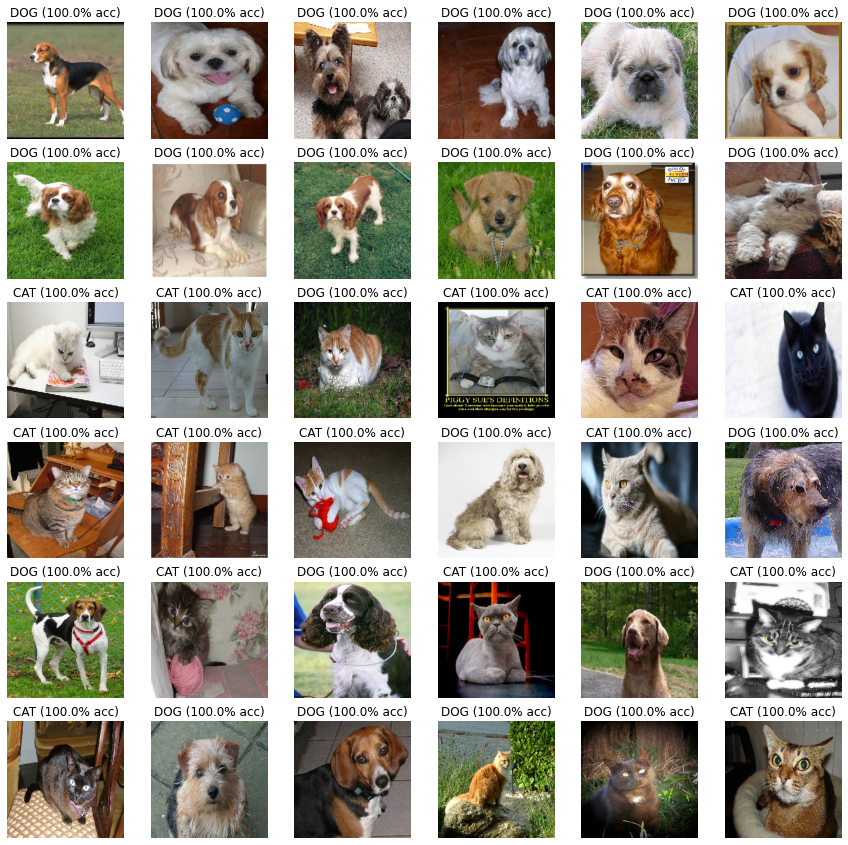

In [9]:
path = "/content/drive/MyDrive/Resolute-AI/intern/day11/predict/"        # change the path accordingly
test_img_ls = os.listdir(path)   


img_arr=[]
predictions =[]
scores =[]

title = ["CAT","DOG"]
threshold  = 0.5
HEIGHT,WIDTH=224,224

for j,i in enumerate(test_img_ls):
  img = tf.keras.preprocessing.image.load_img(
      path+i,target_size = (HEIGHT,WIDTH)
  )
  arr = tf.keras.preprocessing.image.img_to_array(img)
  img_arr.append(arr)
  arr = tf.expand_dims(arr,0)
  pred = model.predict(arr)
  prediction=pred[0][0]
  if prediction <= threshold:
    predictions.append(0)
    scores.append(100*(1-prediction))
  else:
    predictions.append(1)
    scores.append(100*prediction)

scores = [round(i,2) for i in scores]

plt.figure(figsize=(15,15))
for i in range(36):
  ax = plt.subplot(6,6, i + 1)
  plt.imshow(img_arr[i].astype("uint8"))
  text = str(title[predictions[i]])+" ("+str(scores[i])+"% acc)"
  plt.title(text)
  plt.axis("off")